# Rate Limits of ICMPv6 Error Messages

This code allows to evaluate ICMPv6 error message rate limiting implementations.

In [143]:
# SET reproduction to TRUE, if you want to reproduce the figures generated in the paper
REPRODUCTION = True

In [6]:
# Enable auto reloading
%load_ext autoreload
%autoreload 2

In [146]:
# File & Folder handling
INPUT_FOLDER="data/data_ratelimits/"
DEFAULT_FOLDER="data/repro/data_ratelimits/"
SCAN_FOLDER="/scans/2023_07_router_icmpv6_fingerprints/2023-07-20/"
SCAN_FILES_ZMAP_FOLDER=SCAN_FOLDER+"zmap_output/"
SCAN_FILES_PROCESSED_FOLDER=SCAN_FOLDER+"zmap_output_processed/"

# INPUT (NOT PUBLICLY AVAILABLE DUE TO SENSITIVE DATA, request SNMPv3 vendor labels from https://snmpv3.io/; contact the authors for router targets, research only access)
TRACE_FILE=INPUT_FOLDER+"router_targets_ttle_only.csv"
SNMPV3_DOWNLOAD=INPUT_FOLDER+"2023-09-28-udp161-snmpv3.csv"
SNMPV3_DOWNLOAD_FILTERED=SNMPV3_DOWNLOAD.replace(".csv","_filtered.csv")
TARGETS_WITH_ENGINEID=DEFAULT_FOLDER+"targets_with_engineid.csv"
TARGETS_WITH_ENTERPRISE_MAC_VENDORS=DEFAULT_FOLDER+"targets_with_snmpv3_and_mac_vendors.csv"
TARGETS_WITH_VENDOR=DEFAULT_FOLDER+"targets_with_vendor.csv"

if REPRODUCTION==True:
    PROCESSED_FILE=INPUT_FOLDER+"processed_collected_ANONYM.csv"
else:
    PROCESSED_FILE=DEFAULT_FOLDER+"processed_collected_REPRO.csv"

# INPUT FOR REPRODUCTION
PYASN_FILE=INPUT_FOLDER+"ipasn_20230727.dat"
RATES_JSON=INPUT_FOLDER+"rates.json"

# Reproduction Files
MATCH_FILE= DEFAULT_FOLDER + "matches_REPRO.csv"
CDF_SNMPV3 = DEFAULT_FOLDER + "cdf_snmpv3_REPRO.pdf"
CDF_NRPACKETS = DEFAULT_FOLDER + "cdf_nrpackets_REPRO.pdf"
BARS_VENDORS =  DEFAULT_FOLDER + "bars_vendors_REPRO.pdf"

## 1. Collect SNMPv3 Vendor Labels
(SKIP FOR REPRODUCTION)

In [14]:
# SKIP THIS STEP FOR REPRODUCTION

import pandas as pd

df_targets=pd.read_csv(TRACE_FILE)
df_snmpv3_download = pd.read_csv(SNMPV3_DOWNLOAD)

# Filtering df_snmpv3_download based on the source ip column in df_targets
df_snmpv3_download_filtered = df_snmpv3_download[df_snmpv3_download['saddr'].isin(df_targets['source_ip'])]
df_snmpv3_download_filtered.to_csv(SNMPV3_DOWNLOAD_FILTERED, index=False)

In [13]:
# SKIP THIS STEP FOR REPRODUCTION

print("Routers with target and known hops from tracerouting: "+str(len(df_targets)))
print("Routers with SNMPv3 engine IDs: " +str(len(df_snmpv3_download)))
print("Overlap: "+str(len(df_snmpv3_download_filtered)))
# We were not able to collect TX error rates for all overlapping routers, see later steps

Routers with target and known hops from tracerouting: 2570313
Routers with SNMPv3 engine IDs:475964
Overlap: 69867


In [9]:
# SKIP THIS STEP FOR REPRODUCTION

# 1. Execute the bash snippet as stated in the README.md, take the resulting file as input

# 2. Extract the enterprise ID vendor and the vendor from the MAC if the format scheme is 03
from ratelimits.routers.tools.snmpv3.parse_engineid_w_mac import *
from ratelimits.routers.tools.snmpv3.reduce_to_one_vendor import *

# Creates TARGETS_WITH_ENTERPRISE_MAC_VENDORS
parse_engineid_file(TARGETS_WITH_ENGINEID,TARGETS_WITH_ENTERPRISE_MAC_VENDORS)
# Creates TARGETS_WITH_VENDOR
reduce_vendors(TARGETS_WITH_ENTERPRISE_MAC_VENDORS,TARGETS_WITH_VENDOR)


Weird engineid format: <MISSING>
Weird engineid format: <MISSING>
Weird engineid format: <MISSING>
Conflicts: 131


## 2. Measuring TX Rate Limiting of Routers
(SKIP FOR REPRODUCTION)

### Routerscan

See Readme.md for instructions to collect rate limits of IPv6 routers.


## 3. Postprocess Zmap Output

(SKIP FOR REPRODUCTION)

#### 1. zmap_add_distances.py 
```
Input: Folder with unprocessed zmap outputs
The following columns are included in the output files: nrrec,nrsent,orig-dest-ip,classification,saddr,ttl,original_ttl,sent_timestamp_ts,sent_timestamp_us,timestamp_str,timestamp_sent
Output: Folder with processed zmap outputs 
Task: Zmap output is in timestamp format. We take this and calculate the distances between every packet received. Later on we can use this to determine the interpacket timings and interburst timings. 
```
#### 2. collect_zmap_distances.py 
```
Input: Folder with processed zmap outputs
Output: CSV Files that summarize the results 
Task: Output is split accross multiple files, define rate limiting parameters and add metadata to a central file. 
The following columns are added:
dist_nrsent,dist_rec,dist_sent,dist_rec_sum,dist_sent_sum
Example Call:
python3 collect_zmap_distances.py  -f /scans/router_icmpv6_fingerprints/2023-07-20/zmap_processed_new/ -i /opt/IPv6/Hitlist/router_targets_ttle_only.csv -o /scans/router_icmpv6_fingerprints/2023-07-20/processed_matches.csv
```

In [19]:
# 1. Process distances between packets and add this information as new columns to the ZMap files
# (May take some time: 2.5M files ~3hours)
from ratelimits.tools.postprocess.zmap_add_distances import *
add_distances(SCAN_FILES_ZMAP_FOLDER,SCAN_FILES_PROCESSED_FOLDER)

100%|██████████████████████████████| 2570313/2570313 [2:45:25<00:00, 258.96it/s]

Empty  DFs: 742082 (0%)
Echo  DFs: 489 (0%)
Total Targets: 2570313


In [22]:
# 2. Collect processed files into one csv for evaluation and add metadata
from ratelimits.tools.postprocess.collect_zmap_distances import *

# Remove this [:50] testing limit, to include all files, or call this function outside jupyter due to longer runtime
files=listdir_fullpath(SCAN_FILES_PROCESSED_FOLDER)[:50]
iterate_and_collect_files(files,PROCESSED_FILE,TRACE_FILE,TARGETS_WITH_VENDOR,PYASN_FILE,match_src=True,totalpackets=2000)

Metadata Preparation: complete


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 256.45it/s]


## 4. Evaluate Processed File

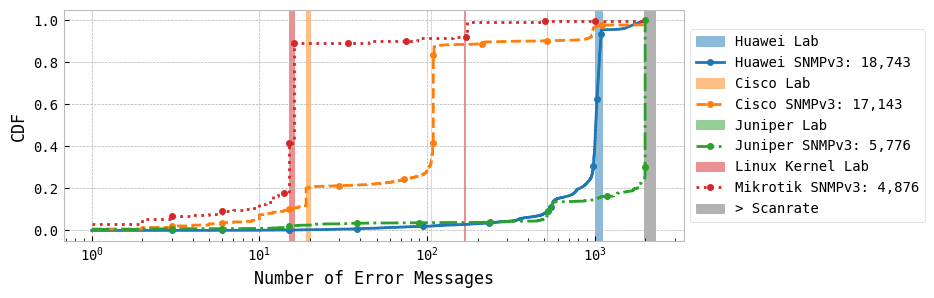

In [147]:
# Visualize rates of routers with SNMPv3 labels that also exist in our lab measurement
from ratelimits.tools.vis.cdf_nrpackets_per_vendor_lab import *

preprocess_and_plot_snmpv3(PROCESSED_FILE,CDF_SNMPV3)

Centrality = 1
Centrality > 1


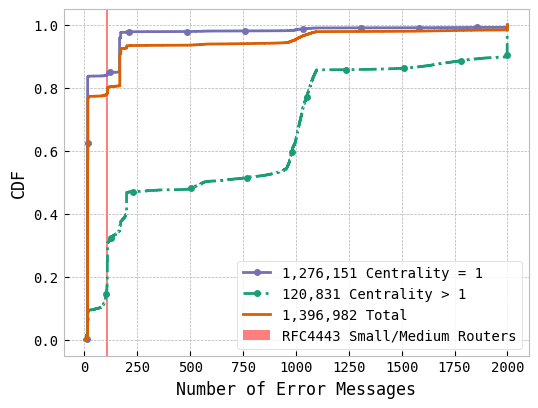

In [148]:
# Visualize error rates for centrality = 1 and centrality > 1
from ratelimits.tools.vis.cdf_nrpackets_total import *
preprocess_and_plot_nrpackets(PROCESSED_FILE,CDF_NRPACKETS)

## Match rates to vendors


The recorded ICMPv6 error message rates are stored in the following format:
```
"Huawei": {
		"ratelimit1":{
			"TYP":"lab",
			"TAG":"NE40",
			"NR10":"1000-1100",
			"timelines":["100-200,100,100,100,100,100,100,100,100,100"],
			"BS":"100-200",
			"RI":1000,
			"RS":100
		},
```

The matching occurs in a three step approach:
1) Select candidate error rates that are within a certain treshhold of the timelines. (Adaptive threshold from 10 to 100 based on number of packets)
2) Within these timelines match rate limiting parameters BS - Bucket Size, RI - Refill Intervall & RS - Refill Size.
3) From these fingerprints the one with the lowest distance to the timeline vector is chosen.

In [150]:
# Assign vendors to the recorded ICMPv6 error rates
from ratelimits.tools.match.timeseries_match import *

orchestrate_error_rate_matching(RATES_JSON,PROCESSED_FILE,MATCH_FILE,response_type="timxceed",labrun=False)


{'100,100,100,100,100,100,100,100,100,100': 'FreeBSD/NetBSD;ratelimit1', '105,100,100,100,100,100,100,100,100,100': 'Fortinet;ratelimit1', '18-20,10,10,10,10,10,10,10,10,10': 'Cisco;ratelimit1', '10,1,1,1,1,1,1,1,1,1': 'Cisco;ratelimit2', '20,10,10,10,10,10,10,10,10,10': 'H3C;ratelimit1', '100-200,100,100,100,100,100,100,100,100,100': 'Huawei;ratelimit1', '100,50,50,50,50,50,50,50,50,50': 'Huawei;ratelimit2', '100-200,99,100,100,100,100,100,100,100,100': 'Huawei;ratelimit3', '53,51,156,0,0,52,52,52,52,50': 'Juniper;ratelimit1', '53,51,53,52,51,52,52,52,52,50': 'Juniper;ratelimit1', '52,52,52,52,52,52,52,52,52,52': 'Juniper;ratelimit1', '12,0,0,0,0,0,0,0,0,0': 'Juniper;ratelimit2', '6,4,4,4,4,4,4,4,4,4': 'Adtran;ratrelimit1', '105-120,100,99,100,100,100,100,100,100,100': 'Extreme, Brocade, H3C, Cisco;ratelimit1', '5,0,0,0,0,0,0,0,0,0': 'HP;ratelimit1', '100,0,0,0,0,0,0,0,0,0': 'Nokia;ratelimit1', '100,0,0,0,0,0,0,0,0,100': 'Nokia;ratelimit1', '100,0,0,0,0,0,0,0,100,0': 'Nokia;ratelimit1

100%|███████████████████████████████| 1684869/1684869 [07:57<00:00, 3526.32it/s]


Rows processed: 1684869
Matching complete
timeline_match_grouped
Linux (<4.9 or >=4.19;/97-/128)    1172671
Linux (>=4.19;/0)                   210157
> Scanrate/∞ 200PPS                  52725
Cisco IOS/IOS XE                     47171
New pattern                          43341
Double rate limit                    36309
Huawei                               34468
Huawei NE                            25869
Nokia                                19056
Cisco IOS XR                         13364
HP                                   11444
Linux (>=4.19;/1-/32)                 6489
FreeBSD/NetBSD                        4779
Extreme, Brocade, H3C, Cisco          3926
Juniper                               2351
Linux (>=4.19;/33-/64)                 383
Fortinet Fortigate                     265
Adtran                                 101
Name: count, dtype: int64


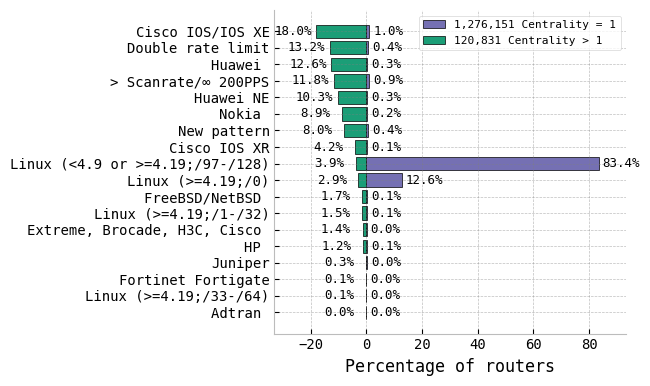

In [152]:
# Visualize the matches
from ratelimits.tools.vis.draw_horizontal_bars_for_match_column import *

preprocess_and_plot_horizontalbars_vendors(MATCH_FILE,BARS_VENDORS)

In [140]:
# Anonymize PROCESSED_FILE for publication:
df = pd.read_csv(PROCESSED_FILE)

df = df.drop(["saddr","original_saddr","asn","network","target_asn","target_network"],axis=1)

df.to_csv(PROCESSED_FILE_ANONYM)